# NFL Sports Betting, Win/Loss and Spread Predicting

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from scipy.stats import zscore

Reading In Scrapped Data

In [2]:
nfl_df = pd.read_csv('nfl_pts_and_vegas_2014-2023.csv')
print(nfl_df.info())
print(nfl_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5214 entries, 0 to 5213
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5214 non-null   int64  
 1   Season      5214 non-null   int64  
 2   Week        5214 non-null   int64  
 3   Team        5214 non-null   object 
 4   Day         5214 non-null   object 
 5   Date        5214 non-null   object 
 6   Win         5214 non-null   int64  
 7   OT          5214 non-null   int64  
 8   Home        5214 non-null   int64  
 9   Opp         5214 non-null   object 
 10  Team_Pts    5214 non-null   int64  
 11  Opp_Pts     5214 non-null   int64  
 12  G           5214 non-null   int64  
 13  Spread      5214 non-null   float64
 14  Total       5214 non-null   float64
dtypes: float64(2), int64(9), object(4)
memory usage: 611.1+ KB
None
      Unnamed: 0  Season  Week Team  Day          Date  Win  OT  Home  Opp  \
0              0    2014     1  MIA  Sun   Septem

Manipulating the Data

In [3]:
nfl_df = nfl_df.drop(nfl_df.columns[0], axis=1)
print(nfl_df)

      Season  Week Team  Day          Date  Win  OT  Home  Opp  Team_Pts  \
0       2014     1  MIA  Sun   September 7    1   0     1  NWE        33   
1       2014     2  MIA  Sun  September 14    0   0     0  BUF        10   
2       2014     3  MIA  Sun  September 21    0   0     1  KAN        15   
3       2014     4  MIA  Sun  September 28    1   0     0  RAI        38   
4       2014     6  MIA  Sun    October 12    0   0     1  GNB        24   
...      ...   ...  ...  ...           ...  ...  ..   ...  ...       ...   
5209    2023    14  SFO  Sun   December 10    1   0     1  SEA        28   
5210    2023    15  SFO  Sun   December 17    1   0     0  CRD        45   
5211    2023    16  SFO  Mon   December 25    0   0     1  RAV        19   
5212    2023    17  SFO  Sun   December 31    1   0     0  WAS        27   
5213    2023    18  SFO  Sun     January 7    0   0     1  RAM        20   

      Opp_Pts   G  Spread  Total  
0          20   1     5.0   47.0  
1          29   2

Dropping Older Seasons(more relevant data for better results)

In [4]:
nfl_df = nfl_df[~nfl_df['Season'].between(2014, 2018)]

Determining the True Total and Comparing to the Betting Total

In [5]:
nfl_df['True_Total'] = nfl_df['Team_Pts'] + nfl_df['Opp_Pts']
nfl_df['Over'] = np.where(nfl_df['True_Total'] > nfl_df['Total'], 1, 0)
nfl_df['Under'] = np.where(nfl_df['True_Total'] < nfl_df['Total'], 1, 0)
nfl_df['Push'] = np.where(nfl_df['True_Total'] == nfl_df['Total'], 1, 0)
print(nfl_df)

      Season  Week Team  Day          Date  Win  OT  Home  Opp  Team_Pts  \
2560    2019     1  MIA  Sun   September 8    0   0     1  RAV        10   
2561    2019     2  MIA  Sun  September 15    0   0     1  NWE         0   
2562    2019     3  MIA  Sun  September 22    0   0     0  DAL         6   
2563    2019     4  MIA  Sun  September 29    0   0     1  SDG        10   
2564    2019     6  MIA  Sun    October 13    0   0     1  WAS        16   
...      ...   ...  ...  ...           ...  ...  ..   ...  ...       ...   
5209    2023    14  SFO  Sun   December 10    1   0     1  SEA        28   
5210    2023    15  SFO  Sun   December 17    1   0     0  CRD        45   
5211    2023    16  SFO  Mon   December 25    0   0     1  RAV        19   
5212    2023    17  SFO  Sun   December 31    1   0     0  WAS        27   
5213    2023    18  SFO  Sun     January 7    0   0     1  RAM        20   

      Opp_Pts   G  Spread  Total  True_Total  Over  Under  Push  
2560       59   1    

Sorting by Season and Week

In [6]:
nfl_df = nfl_df.sort_values(by=['Season', 'Week']).reset_index(drop=True)

In [7]:
df = nfl_df.query('Home == 1').reset_index(drop=True)

Encoding Team names to Numerical Values

In [8]:
# Encode categorical variables
le = LabelEncoder()
df['Team'] = le.fit_transform(df['Team'])
df['Opp'] = le.transform(df['Opp'])

print(df['Team'].unique())
print(le.classes_)
print(le.inverse_transform([i for i in range(0,32)]))

[15 18 20  5 13 27 24 22  8 16  3 17  2 30 28  7 23 26  4 21 12  9 31 19
 10 11  0 25  1  6 14 29]
['ATL' 'BUF' 'CAR' 'CHI' 'CIN' 'CLE' 'CLT' 'CRD' 'DAL' 'DEN' 'DET' 'GNB'
 'HTX' 'JAX' 'KAN' 'MIA' 'MIN' 'NOR' 'NWE' 'NYG' 'NYJ' 'OTI' 'PHI' 'PIT'
 'RAI' 'RAM' 'RAV' 'SDG' 'SEA' 'SFO' 'TAM' 'WAS']
['ATL' 'BUF' 'CAR' 'CHI' 'CIN' 'CLE' 'CLT' 'CRD' 'DAL' 'DEN' 'DET' 'GNB'
 'HTX' 'JAX' 'KAN' 'MIA' 'MIN' 'NOR' 'NWE' 'NYG' 'NYJ' 'OTI' 'PHI' 'PIT'
 'RAI' 'RAM' 'RAV' 'SDG' 'SEA' 'SFO' 'TAM' 'WAS']


Copying the Origninal Dataset for Later Use

In [9]:
nfl_df2 = df.copy()

features = ['Spread', 'Total']
Target = 'Under'

print(nfl_df2)

      Season  Week  Team  Day         Date  Win  OT  Home  Opp  Team_Pts  \
0       2019     1    15  Sun  September 8    0   0     1   26        10   
1       2019     1    18  Sun  September 8    1   0     1   23        33   
2       2019     1    20  Sun  September 8    0   0     1    1        16   
3       2019     1     5  Sun  September 8    0   0     1   21        13   
4       2019     1    13  Sun  September 8    0   0     1   14        26   
...      ...   ...   ...  ...          ...  ...  ..   ...  ...       ...   
1322    2023    18    11  Sun    January 7    1   0     1    3        17   
1323    2023    18    17  Sun    January 7    1   0     1    0        48   
1324    2023    18     2  Sun    January 7    0   0     1   30         0   
1325    2023    18     7  Sun    January 7    0   0     1   28        20   
1326    2023    18    29  Sun    January 7    0   0     1   25        20   

      Opp_Pts   G  Spread  Total  True_Total  Over  Under  Push  
0          59   1    

First Prediction:
Predicting whether the total wil be under the betting line total

Results for 2021
Week  1: 

accuracy score = 43.75%
Week  2: accuracy score = 31.25%
Week  3: accuracy score = 56.25%
Week  4: accuracy score = 37.50%
Week  5: accuracy score = 56.25%
Week  6: accuracy score = 38.46%
Week  7: accuracy score = 61.54%
Week  8: accuracy score = 50.00%
Week  9: accuracy score = 61.54%
Week 10: accuracy score = 53.85%
Week 11: accuracy score = 73.33%
Week 12: accuracy score = 60.00%
Week 13: accuracy score = 50.00%
Week 14: accuracy score = 38.46%
Week 15: accuracy score = 50.00%
Week 16: accuracy score = 75.00%
Week 17: accuracy score = 61.54%
Week 18: accuracy score = 57.14%
Season 2021: Total Accuracy Score = 53.05%

Classification Report for 2021:
              precision    recall  f1-score   support

        Over       0.50      0.52      0.51       122
       Under       0.56      0.54      0.55       140

    accuracy                           0.53       262
   macro avg       0.53      0.53      0.53       262
weighted avg       0.53      0.53      0.53       262



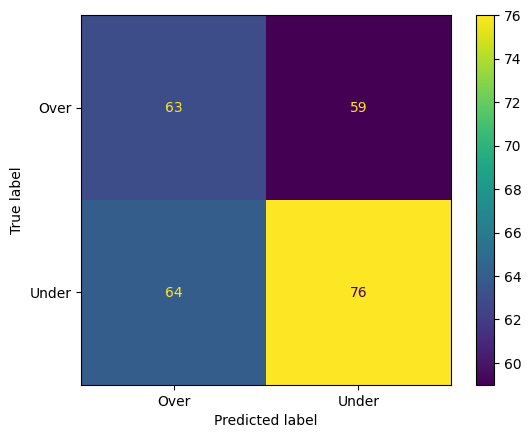

Results for 2022
Week  1: accuracy score = 43.75%
Week  2: accuracy score = 56.25%
Week  3: accuracy score = 66.67%
Week  4: accuracy score = 62.50%
Week  5: accuracy score = 56.25%
Week  6: accuracy score = 57.14%
Week  7: accuracy score = 61.54%
Week  8: accuracy score = 42.86%
Week  9: accuracy score = 38.46%
Week 10: accuracy score = 57.14%
Week 11: accuracy score = 28.57%
Week 12: accuracy score = 62.50%
Week 13: accuracy score = 46.67%
Week 14: accuracy score = 76.92%
Week 15: accuracy score = 56.25%
Week 16: accuracy score = 50.00%
Week 17: accuracy score = 50.00%
Week 18: accuracy score = 46.67%
Season 2022: Total Accuracy Score = 53.41%

Classification Report for 2022:
              precision    recall  f1-score   support

        Over       0.48      0.57      0.52       117
       Under       0.60      0.50      0.55       147

    accuracy                           0.53       264
   macro avg       0.54      0.54      0.53       264
weighted avg       0.54      0.53      0.

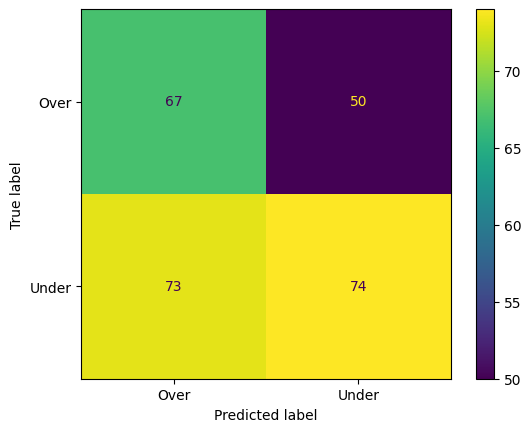

Results for 2023
Week  1: accuracy score = 60.00%
Week  2: accuracy score = 37.50%
Week  3: accuracy score = 56.25%
Week  4: accuracy score = 62.50%
Week  5: accuracy score = 57.14%
Week  6: accuracy score = 50.00%
Week  7: accuracy score = 53.85%
Week  8: accuracy score = 37.50%
Week  9: accuracy score = 46.15%
Week 10: accuracy score = 61.54%
Week 11: accuracy score = 40.00%
Week 12: accuracy score = 56.25%
Week 13: accuracy score = 61.54%
Week 14: accuracy score = 46.15%
Week 15: accuracy score = 53.33%
Week 16: accuracy score = 28.57%
Week 17: accuracy score = 50.00%
Week 18: accuracy score = 35.71%
Season 2023: Total Accuracy Score = 49.80%

Classification Report for 2023:
              precision    recall  f1-score   support

        Over       0.44      0.43      0.43       114
       Under       0.55      0.55      0.55       141

    accuracy                           0.50       255
   macro avg       0.49      0.49      0.49       255
weighted avg       0.50      0.50      0.

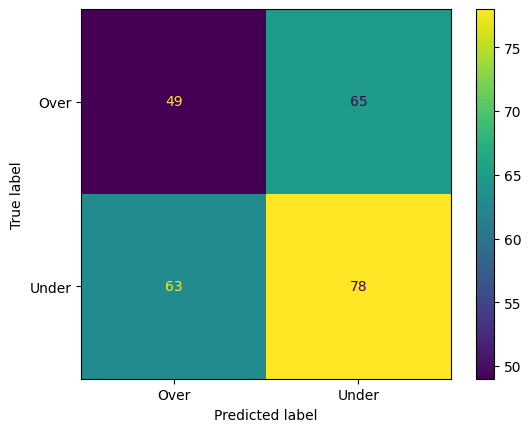

In [10]:
for season in [2021, 2022, 2023]:
    print(f'Results for {season}')
    
    y_preds = []
    y_trues = []
    
    for week in range(1, 19):
        print(f'Week {week:>2}:', end=' ')
        
        train_df = nfl_df2.query('Season < @season or (Season == @season and Week < @week)')
        
        test_df = nfl_df2.query('Season == @season and Week == @week and True_Total != Total')
        
        X_train = train_df[features]
        y_train = train_df[Target]
        X_test = test_df[features]
        y_test = test_df[Target]
        
        model =KNeighborsClassifier(n_neighbors=7)
        
        # Pipeline for scaler and model predictions
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('model', KNeighborsClassifier(n_neighbors=7))
        ])
        
        #clf = model.fit(X_train, y_train)
        clf = pipe.fit(X_train, y_train)
        
        # Pipeline for LOF outlier detection
        pipe_outlier = Pipeline([
            ('scaler', StandardScaler()),
            ('lof', LocalOutlierFactor(novelty=True))
        ])
        
        pipe_outlier.fit(X_train)
        
        # Filter outliers using LoF
        y_test_novelty = pipe_outlier.predict(X_test)
        mask = [y == 1 for y in y_test_novelty]
        
        X_test = X_test[mask]
        y_test = y_test[mask]
        
        y_pred = clf.predict(X_test)
        y_true = y_test
        
        print(f'accuracy score = {accuracy_score(y_true, y_pred):.2%}')
        
        y_preds += list(y_pred)
        y_trues += list(y_true)
        
    print(f'Season {season}: Total Accuracy Score = {accuracy_score(y_trues, y_preds):.2%}')
    print(f'\nClassification Report for {season}:')
    print(classification_report(y_trues, y_preds, target_names=['Over', 'Under']))
    
    cm = confusion_matrix(y_trues, y_preds)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Over', 'Under'])
    display.plot()
    plt.grid(False)
    plt.show()

Prediction 2: Predicting Wins based on Team name, Opposing Team name, spread, and total betting line

In [11]:
nfl_df3 = df.copy()

# Define features and target
features = ['Team', 'Opp', 'Spread', 'Total']
target = 'Win'

print(nfl_df3)

      Season  Week  Team  Day         Date  Win  OT  Home  Opp  Team_Pts  \
0       2019     1    15  Sun  September 8    0   0     1   26        10   
1       2019     1    18  Sun  September 8    1   0     1   23        33   
2       2019     1    20  Sun  September 8    0   0     1    1        16   
3       2019     1     5  Sun  September 8    0   0     1   21        13   
4       2019     1    13  Sun  September 8    0   0     1   14        26   
...      ...   ...   ...  ...          ...  ...  ..   ...  ...       ...   
1322    2023    18    11  Sun    January 7    1   0     1    3        17   
1323    2023    18    17  Sun    January 7    1   0     1    0        48   
1324    2023    18     2  Sun    January 7    0   0     1   30         0   
1325    2023    18     7  Sun    January 7    0   0     1   28        20   
1326    2023    18    29  Sun    January 7    0   0     1   25        20   

      Opp_Pts   G  Spread  Total  True_Total  Over  Under  Push  
0          59   1    

Results for 2021
Week  1: accuracy = 43.75%
Week  2: accuracy = 62.50%
Week  3: accuracy = 50.00%
Week  4: accuracy = 62.50%
Week  5: accuracy = 56.25%
Week  6: accuracy = 57.14%
Week  7: accuracy = 61.54%
Week  8: accuracy = 53.33%
Week  9: accuracy = 57.14%
Week 10: accuracy = 57.14%
Week 11: accuracy = 66.67%
Week 12: accuracy = 60.00%
Week 13: accuracy = 64.29%
Week 14: accuracy = 64.29%
Week 15: accuracy = 56.25%
Week 16: accuracy = 68.75%
Week 17: accuracy = 81.25%
Week 18: accuracy = 56.25%

Season 2021: Total Accuracy Score = 59.93%
Classification Report for 2021:
              precision    recall  f1-score   support

    Away Win       0.59      0.58      0.59       132
    Home Win       0.61      0.61      0.61       140

    accuracy                           0.60       272
   macro avg       0.60      0.60      0.60       272
weighted avg       0.60      0.60      0.60       272



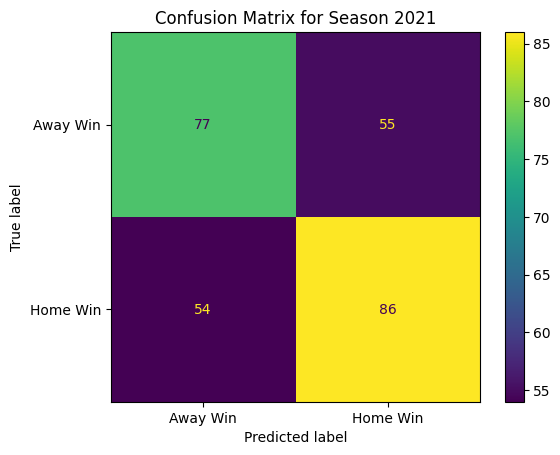

Results for 2022
Week  1: accuracy = 50.00%
Week  2: accuracy = 56.25%
Week  3: accuracy = 56.25%
Week  4: accuracy = 50.00%
Week  5: accuracy = 75.00%
Week  6: accuracy = 42.86%
Week  7: accuracy = 35.71%
Week  8: accuracy = 53.33%
Week  9: accuracy = 69.23%
Week 10: accuracy = 57.14%
Week 11: accuracy = 57.14%
Week 12: accuracy = 62.50%
Week 13: accuracy = 66.67%
Week 14: accuracy = 46.15%
Week 15: accuracy = 81.25%
Week 16: accuracy = 73.33%
Week 17: accuracy = 60.00%
Week 18: accuracy = 68.75%

Season 2022: Total Accuracy Score = 59.26%
Classification Report for 2022:
              precision    recall  f1-score   support

    Away Win       0.54      0.54      0.54       120
    Home Win       0.63      0.63      0.63       150

    accuracy                           0.59       270
   macro avg       0.59      0.59      0.59       270
weighted avg       0.59      0.59      0.59       270



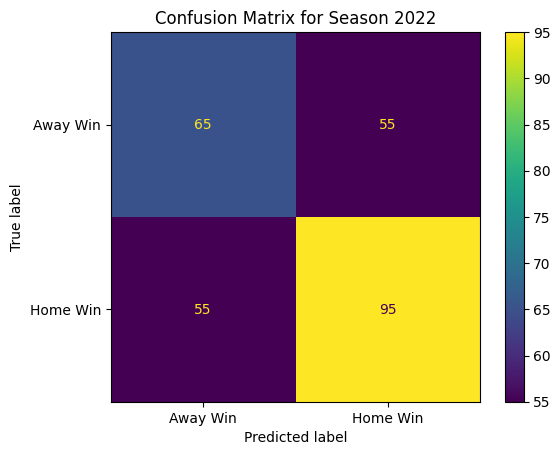

Results for 2023
Week  1: accuracy = 62.50%
Week  2: accuracy = 75.00%
Week  3: accuracy = 56.25%
Week  4: accuracy = 50.00%
Week  5: accuracy = 64.29%
Week  6: accuracy = 60.00%
Week  7: accuracy = 46.15%
Week  8: accuracy = 62.50%
Week  9: accuracy = 64.29%
Week 10: accuracy = 64.29%
Week 11: accuracy = 64.29%
Week 12: accuracy = 81.25%
Week 13: accuracy = 69.23%
Week 14: accuracy = 42.86%
Week 15: accuracy = 80.00%
Week 16: accuracy = 68.75%
Week 17: accuracy = 73.33%
Week 18: accuracy = 50.00%

Season 2023: Total Accuracy Score = 63.20%
Classification Report for 2023:
              precision    recall  f1-score   support

    Away Win       0.58      0.63      0.60       119
    Home Win       0.68      0.63      0.66       150

    accuracy                           0.63       269
   macro avg       0.63      0.63      0.63       269
weighted avg       0.64      0.63      0.63       269



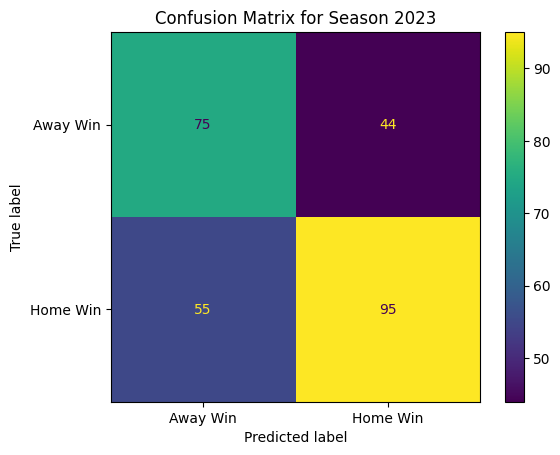

In [12]:
# Iterate over multiple seasons
for season in [2021, 2022, 2023]:
    print(f'Results for {season}')
    
    y_preds = []
    y_trues = []
    
    for week in range(1, 19):
        print(f'Week {week:>2}:', end=' ')
        
        # Train on all data before the current season and week
        train_df = nfl_df3.query('Season < @season or (Season == @season and Week < @week)')
        test_df = nfl_df3.query('Season == @season and Week == @week')
        
        # Assign training and testing data
        X_train = train_df[features]
        y_train = train_df[target]
        X_test = test_df[features]
        y_test = test_df[target]
        
        # Train k-NN model
        model = KNeighborsClassifier(n_neighbors=7)
        
        # Pipline for scaler and model predictions
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('model', KNeighborsClassifier(n_neighbors=7))
        ])
        
        #clf = model.fit(X_train, y_train)
        clf = pipe.fit(X_train, y_train)
        
        # Pipeline for LOF outlier detection
        pipe_outlier = Pipeline([
            ('scaler', StandardScaler()),
            ('lof', LocalOutlierFactor(novelty=True))
        ])
        
        pipe_outlier.fit(X_train)
        
        # Filter outliers using LoF
        y_test_novelty = pipe_outlier.predict(X_test)
        mask = [y == 1 for y in y_test_novelty]
        
        X_test = X_test[mask]
        y_test = y_test[mask]
        
        y_pred = clf.predict(X_test)
        y_true = y_test
        
        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)
        print(f'accuracy = {accuracy:.2%}')
        
        y_preds += list(y_pred)
        y_trues += list(y_true)
    
    # Season-wide evaluation
    overall_accuracy = accuracy_score(y_trues, y_preds)
    print(f'\nSeason {season}: Total Accuracy Score = {overall_accuracy:.2%}')
    print(f'Classification Report for {season}:\n{classification_report(y_trues, y_preds, target_names=["Away Win", "Home Win"])}')
    
    # Confusion Matrix
    cm = confusion_matrix(y_trues, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Away Win", "Home Win"])
    disp.plot()
    plt.title(f"Confusion Matrix for Season {season}")
    plt.grid(False)
    plt.show()

Results for 2021
Week  1: accuracy = 50.00%
Week  2: accuracy = 62.50%
Week  3: accuracy = 68.75%
Week  4: accuracy = 68.75%
Week  5: accuracy = 56.25%
Week  6: accuracy = 42.86%
Week  7: accuracy = 76.92%
Week  8: accuracy = 66.67%
Week  9: accuracy = 35.71%
Week 10: accuracy = 57.14%
Week 11: accuracy = 40.00%
Week 12: accuracy = 53.33%
Week 13: accuracy = 57.14%
Week 14: accuracy = 78.57%
Week 15: accuracy = 62.50%
Week 16: accuracy = 56.25%
Week 17: accuracy = 75.00%
Week 18: accuracy = 62.50%

Season 2021: Total Accuracy Score = 59.56%
Classification Report for 2021:
              precision    recall  f1-score   support

    Away Win       0.59      0.56      0.57       132
    Home Win       0.60      0.63      0.62       140

    accuracy                           0.60       272
   macro avg       0.60      0.59      0.59       272
weighted avg       0.60      0.60      0.60       272



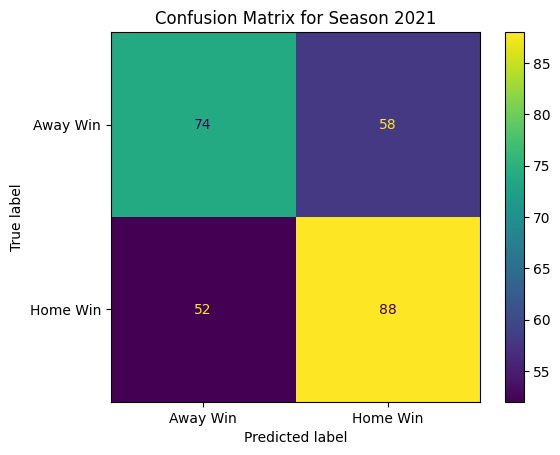

Results for 2022
Week  1: accuracy = 50.00%
Week  2: accuracy = 50.00%
Week  3: accuracy = 50.00%
Week  4: accuracy = 56.25%
Week  5: accuracy = 75.00%
Week  6: accuracy = 28.57%
Week  7: accuracy = 35.71%
Week  8: accuracy = 66.67%
Week  9: accuracy = 61.54%
Week 10: accuracy = 57.14%
Week 11: accuracy = 64.29%
Week 12: accuracy = 68.75%
Week 13: accuracy = 86.67%
Week 14: accuracy = 46.15%
Week 15: accuracy = 75.00%
Week 16: accuracy = 73.33%
Week 17: accuracy = 60.00%
Week 18: accuracy = 75.00%

Season 2022: Total Accuracy Score = 60.37%
Classification Report for 2022:
              precision    recall  f1-score   support

    Away Win       0.55      0.58      0.57       120
    Home Win       0.65      0.62      0.63       150

    accuracy                           0.60       270
   macro avg       0.60      0.60      0.60       270
weighted avg       0.61      0.60      0.60       270



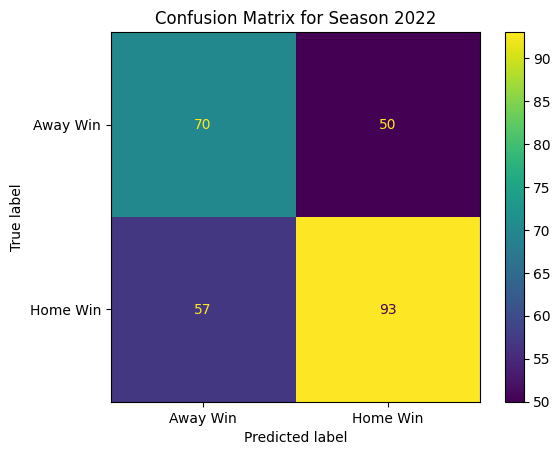

Results for 2023
Week  1: accuracy = 62.50%
Week  2: accuracy = 75.00%
Week  3: accuracy = 50.00%
Week  4: accuracy = 62.50%
Week  5: accuracy = 57.14%
Week  6: accuracy = 60.00%
Week  7: accuracy = 38.46%
Week  8: accuracy = 68.75%
Week  9: accuracy = 71.43%
Week 10: accuracy = 71.43%
Week 11: accuracy = 57.14%
Week 12: accuracy = 50.00%
Week 13: accuracy = 53.85%
Week 14: accuracy = 42.86%
Week 15: accuracy = 73.33%
Week 16: accuracy = 62.50%
Week 17: accuracy = 66.67%
Week 18: accuracy = 62.50%

Season 2023: Total Accuracy Score = 60.59%
Classification Report for 2023:
              precision    recall  f1-score   support

    Away Win       0.56      0.55      0.55       119
    Home Win       0.64      0.65      0.65       150

    accuracy                           0.61       269
   macro avg       0.60      0.60      0.60       269
weighted avg       0.61      0.61      0.61       269



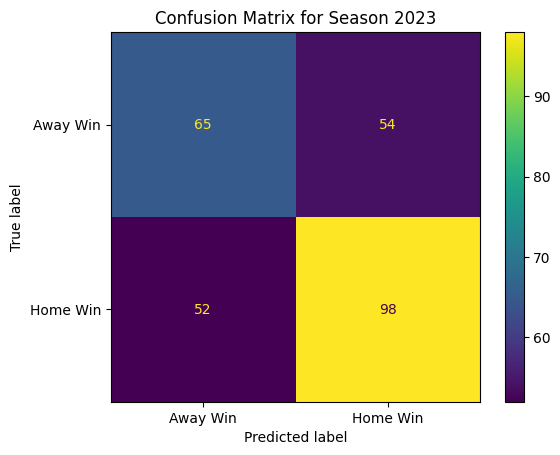

In [13]:
# Iterate over multiple seasons
for season in [2021, 2022, 2023]:
    print(f'Results for {season}')
    
    y_preds = []
    y_trues = []
    
    for week in range(1, 19):
        print(f'Week {week:>2}:', end=' ')
        
        # Train on all data before the current season and week
        train_df = nfl_df3.query('Season < @season or (Season == @season and Week < @week)')
        test_df = nfl_df3.query('Season == @season and Week == @week')
        
        # Assign training and testing data
        X_train = train_df[features]
        y_train = train_df[target]
        X_test = test_df[features]
        y_test = test_df[target]
        
        # Train k-NN model
        model = RandomForestClassifier(random_state=42, n_estimators=100)
        
        # Pipline for scaler and model predictions
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('model', RandomForestClassifier(random_state=42, n_estimators=100))
        ])
        
        #clf = model.fit(X_train, y_train)
        clf = pipe.fit(X_train, y_train)
        
        # Pipeline for LOF outlier detection
        pipe_outlier = Pipeline([
            ('scaler', StandardScaler()),
            ('lof', LocalOutlierFactor(novelty=True))
        ])
        
        pipe_outlier.fit(X_train)
        
        # Filter outliers using LoF
        y_test_novelty = pipe_outlier.predict(X_test)
        mask = [y == 1 for y in y_test_novelty]
        
        X_test = X_test[mask]
        y_test = y_test[mask]
        
        y_pred = clf.predict(X_test)
        y_true = y_test
        
        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)
        print(f'accuracy = {accuracy:.2%}')
        
        y_preds += list(y_pred)
        y_trues += list(y_true)
    
    # Season-wide evaluation
    overall_accuracy = accuracy_score(y_trues, y_preds)
    print(f'\nSeason {season}: Total Accuracy Score = {overall_accuracy:.2%}')
    print(f'Classification Report for {season}:\n{classification_report(y_trues, y_preds, target_names=["Away Win", "Home Win"])}')
    
    # Confusion Matrix
    cm = confusion_matrix(y_trues, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Away Win", "Home Win"])
    disp.plot()
    plt.title(f"Confusion Matrix for Season {season}")
    plt.grid(False)
    plt.show()

Prediction 3: Predicting the Point value and Spread

In [14]:
nfl_df4 = df.copy()

# Define features and targets
features = ['Spread', 'Total', 'True_Total', 'Over', 'Under']  # Add other features if relevant
target_home = 'Team_Pts'
target_away = 'Opp_Pts'

print(nfl_df4)

      Season  Week  Team  Day         Date  Win  OT  Home  Opp  Team_Pts  \
0       2019     1    15  Sun  September 8    0   0     1   26        10   
1       2019     1    18  Sun  September 8    1   0     1   23        33   
2       2019     1    20  Sun  September 8    0   0     1    1        16   
3       2019     1     5  Sun  September 8    0   0     1   21        13   
4       2019     1    13  Sun  September 8    0   0     1   14        26   
...      ...   ...   ...  ...          ...  ...  ..   ...  ...       ...   
1322    2023    18    11  Sun    January 7    1   0     1    3        17   
1323    2023    18    17  Sun    January 7    1   0     1    0        48   
1324    2023    18     2  Sun    January 7    0   0     1   30         0   
1325    2023    18     7  Sun    January 7    0   0     1   28        20   
1326    2023    18    29  Sun    January 7    0   0     1   25        20   

      Opp_Pts   G  Spread  Total  True_Total  Over  Under  Push  
0          59   1    

In [15]:
# Iterate over multiple seasons
for season in [2021, 2022, 2023]:
    print(f'\nResults for {season}')
    
    y_preds_home = []
    y_trues_home = []
    y_preds_away = []
    y_trues_away = []
    
    for week in range(1, 19):
        print(f'Week {week:>2}:', end=' ')
        
        # Train on all data before the current season and week
        train_df = nfl_df4.query('Season < @season or (Season == @season and Week < @week)')
        test_df = nfl_df4.query('Season == @season and Week == @week')
        
        # Assign training and testing data
        X_train = train_df[features]
        y_train_home = train_df[target_home]
        y_train_away = train_df[target_away]
        X_test = test_df[features]
        y_test_home = test_df[target_home]
        y_test_away = test_df[target_away]
        
        # Pipeline for scaler and model prediction
        pipe_home = Pipeline([
            ('scaler', StandardScaler()),
            ('model', KNeighborsRegressor(n_neighbors=7))
        ])
        pipe_away = Pipeline([
            ('scaler', StandardScaler()),
            ('model', KNeighborsRegressor(n_neighbors=7))
        ])
        
        # Fit the models
        clf_home = pipe_home.fit(X_train, y_train_home)
        clf_away = pipe_away.fit(X_train, y_train_away)
        
        # pipeline for scaler and outlier detection
        pipe_outlier = Pipeline([
            ('scaler', StandardScaler()),
            ('lof', LocalOutlierFactor(novelty=True))
        ])
        
        pipe_outlier.fit(X_train)
        
        # Filter outliers using LoF
        y_test_novelty = pipe_outlier.predict(X_test)
        mask = [y == 1 for y in y_test_novelty]
        X_test = X_test[mask]
        y_test_home = y_test_home[mask]
        y_test_away = y_test_away[mask]
        
        # Make Predictions
        y_pred_home = clf_home.predict(X_test)
        y_pred_away = clf_away.predict(X_test)
        
        # Calculate metrics
        mse_home = mean_squared_error(y_test_home, y_pred_home)
        mse_away = mean_squared_error(y_test_away, y_pred_away)
        
        print(f'MSE Home = {mse_home:.4f}, MSE Away = {mse_away:.4f}')
        
        # Append predictions and true values to lists
        y_preds_home.extend(y_pred_home)
        y_trues_home.extend(y_test_home)
        y_preds_away.extend(y_pred_away)
        y_trues_away.extend(y_test_away)
    
    # Season-wide evaluation
    overall_mse_home = mean_squared_error(y_trues_home, y_preds_home)
    overall_r2_home = r2_score(y_trues_home, y_preds_home)
    overall_mse_away = mean_squared_error(y_trues_away, y_preds_away)
    overall_r2_away = r2_score(y_trues_away, y_preds_away)
    
    print(f'\nSeason {season}: Home Points - MSE = {overall_mse_home:.4f}, R² = {overall_r2_home:.4f}')
    print(f'Season {season}: Away Points - MSE = {overall_mse_away:.4f}, R² = {overall_r2_away:.4f}')


Results for 2021
Week  1: MSE Home = 66.6926, MSE Away = 72.9885
Week  2: MSE Home = 36.7895, MSE Away = 27.3291
Week  3: MSE Home = 28.1926, MSE Away = 40.5319
Week  4: MSE Home = 53.3724, MSE Away = 50.6237
Week  5: MSE Home = 43.5347, MSE Away = 38.3061
Week  6: MSE Home = 57.6327, MSE Away = 58.4961
Week  7: MSE Home = 81.1429, MSE Away = 91.9150
Week  8: MSE Home = 51.6647, MSE Away = 47.1545
Week  9: MSE Home = 64.9984, MSE Away = 64.7316
Week 10: MSE Home = 139.0188, MSE Away = 134.7645
Week 11: MSE Home = 49.1516, MSE Away = 41.6822
Week 12: MSE Home = 51.2476, MSE Away = 55.9224
Week 13: MSE Home = 38.6968, MSE Away = 37.8528
Week 14: MSE Home = 50.3454, MSE Away = 48.5306
Week 15: MSE Home = 48.0789, MSE Away = 51.0136
Week 16: MSE Home = 64.8878, MSE Away = 53.1161
Week 17: MSE Home = 56.8776, MSE Away = 40.8195
Week 18: MSE Home = 39.2988, MSE Away = 41.5583

Season 2021: Home Points - MSE = 55.8694, R² = 0.4893
Season 2021: Away Points - MSE = 54.5192, R² = 0.4404

Result

In [16]:
nfl_df5 = df.copy()

# Define features and targets
features = ['Spread', 'Team', 'Opp', 'Home']  # Add other features if relevant
target_home = 'Team_Pts'
target_away = 'Opp_Pts'

print(nfl_df5)

      Season  Week  Team  Day         Date  Win  OT  Home  Opp  Team_Pts  \
0       2019     1    15  Sun  September 8    0   0     1   26        10   
1       2019     1    18  Sun  September 8    1   0     1   23        33   
2       2019     1    20  Sun  September 8    0   0     1    1        16   
3       2019     1     5  Sun  September 8    0   0     1   21        13   
4       2019     1    13  Sun  September 8    0   0     1   14        26   
...      ...   ...   ...  ...          ...  ...  ..   ...  ...       ...   
1322    2023    18    11  Sun    January 7    1   0     1    3        17   
1323    2023    18    17  Sun    January 7    1   0     1    0        48   
1324    2023    18     2  Sun    January 7    0   0     1   30         0   
1325    2023    18     7  Sun    January 7    0   0     1   28        20   
1326    2023    18    29  Sun    January 7    0   0     1   25        20   

      Opp_Pts   G  Spread  Total  True_Total  Over  Under  Push  
0          59   1    

In [17]:
# Iterate over multiple seasons
for season in [2021, 2022, 2023]:
    print(f'\nResults for {season}')
    
    y_preds_home = []
    y_trues_home = []
    y_preds_away = []
    y_trues_away = []
    
    for week in range(1, 19):
        print(f'Week {week:>2}:', end=' ')
        
        # Train on all data before the current season and week
        train_df = nfl_df5.query('Season < @season or (Season == @season and Week < @week)')
        test_df = nfl_df5.query('Season == @season and Week == @week')
        
        # Assign training and testing data
        X_train = train_df[features]
        y_train_home = train_df[target_home]
        y_train_away = train_df[target_away]
        X_test = test_df[features]
        y_test_home = test_df[target_home]
        y_test_away = test_df[target_away]
        
        # Pipelines for home and away points
        pipe_home = Pipeline([
            ('scaler', StandardScaler()),
            ('model', KNeighborsRegressor(n_neighbors=7))
        ])
        pipe_away = Pipeline([
            ('scaler', StandardScaler()),
            ('model', KNeighborsRegressor(n_neighbors=7))
        ])
        
        # Pipeline for LOF outlier detection
        pipeline_outlier = Pipeline([
            ('scaler', StandardScaler()),
            ('lof', LocalOutlierFactor(novelty=True))
        ])
        
        
        pipeline_outlier.fit(X_train)
        
        # Filter outliers using LoF
        y_test_novelty = pipeline_outlier.predict(X_test)
        mask = [y == 1 for y in y_test_novelty]
        X_test = X_test[mask]
        y_test_home = y_test_home[mask]
        y_test_away = y_test_away[mask]
        
        # Train models
        pipe_home.fit(X_train, y_train_home)
        pipe_away.fit(X_train, y_train_away)
        
        # Make predictions
        y_pred_home = pipe_home.predict(X_test)
        y_pred_away = pipe_away.predict(X_test)
        
        # Calculate metrics
        mse_home = mean_squared_error(y_test_home, y_pred_home)
        mse_away = mean_squared_error(y_test_away, y_pred_away)
        
        print(f'MSE Home = {mse_home:.4f}, MSE Away = {mse_away:.4f}')
        
        # Append predictions
        y_preds_home.extend(y_pred_home)
        y_trues_home.extend(y_test_home)
        y_preds_away.extend(y_pred_away)
        y_trues_away.extend(y_test_away)
    
    # Season-wide evaluation
    overall_mse_home = mean_squared_error(y_trues_home, y_preds_home)
    overall_r2_home = r2_score(y_trues_home, y_preds_home)
    overall_mse_away = mean_squared_error(y_trues_away, y_preds_away)
    overall_r2_away = r2_score(y_trues_away, y_preds_away)
    
    print(f'\nSeason {season}: Home Points - MSE = {overall_mse_home:.4f}, R² = {overall_r2_home:.4f}')
    print(f'Season {season}: Away Points - MSE = {overall_mse_away:.4f}, R² = {overall_r2_away:.4f}')


Results for 2021
Week  1: MSE Home = 133.8253, MSE Away = 89.7717
Week  2: MSE Home = 123.4885, MSE Away = 50.8316
Week  3: MSE Home = 97.6161, MSE Away = 101.0153
Week  4: MSE Home = 67.7741, MSE Away = 82.0218
Week  5: MSE Home = 98.4184, MSE Away = 81.7666
Week  6: MSE Home = 92.0058, MSE Away = 118.7755
Week  7: MSE Home = 111.1554, MSE Away = 204.3171
Week  8: MSE Home = 112.8054, MSE Away = 94.0150
Week  9: MSE Home = 99.5777, MSE Away = 94.4019
Week 10: MSE Home = 152.0466, MSE Away = 214.6735
Week 11: MSE Home = 123.8884, MSE Away = 88.3796
Week 12: MSE Home = 94.5619, MSE Away = 89.3551
Week 13: MSE Home = 87.6108, MSE Away = 73.4096
Week 14: MSE Home = 100.1501, MSE Away = 77.9329
Week 15: MSE Home = 117.4748, MSE Away = 122.2122
Week 16: MSE Home = 165.3393, MSE Away = 46.3622
Week 17: MSE Home = 108.4435, MSE Away = 84.0395
Week 18: MSE Home = 80.4107, MSE Away = 103.1276

Season 2021: Home Points - MSE = 109.4952, R² = 0.0164
Season 2021: Away Points - MSE = 99.3910, R² =

Prediction 4: Predicting Point values and Spread with improved outlier detection using randomforest

In [18]:
# Iterate over multiple seasons
for season in [2021, 2022, 2023]:
    print(f'\nResults for {season}')
    
    y_preds_home = []
    y_trues_home = []
    y_preds_away = []
    y_trues_away = []
    
    for week in range(1, 19):
        print(f'Week {week:>2}:', end=' ')
        
        # Train on all data before the current season and week
        train_df = nfl_df5.query('Season < @season or (Season == @season and Week < @week)')
        test_df = nfl_df5.query('Season == @season and Week == @week')
        
        # Assign training and testing data
        X_train = train_df[features]
        y_train_home = train_df[target_home]
        y_train_away = train_df[target_away]
        X_test = test_df[features]
        y_test_home = test_df[target_home]
        y_test_away = test_df[target_away]
        
        # Pipelines for home and away points
        pipe_home = Pipeline([
            ('scaler', StandardScaler()),
            ('model', RandomForestRegressor(random_state=42, n_estimators=100))
        ])
        pipe_away = Pipeline([
            ('scaler', StandardScaler()),
            ('model', RandomForestRegressor(random_state=42, n_estimators=100))
        ])
        
        # Pipeline for LOF outlier detection
        pipeline_outlier = Pipeline([
            ('scaler', StandardScaler()),
            ('lof', LocalOutlierFactor(novelty=True))
        ])
        
        
        pipeline_outlier.fit(X_train)
        
        # Filter outliers using LoF
        y_test_novelty = pipeline_outlier.predict(X_test)
        mask = [y == 1 for y in y_test_novelty]
        X_test = X_test[mask]
        y_test_home = y_test_home[mask]
        y_test_away = y_test_away[mask]
        
        # Train models
        pipe_home.fit(X_train, y_train_home)
        pipe_away.fit(X_train, y_train_away)
        
        # Make predictions
        y_pred_home = pipe_home.predict(X_test)
        y_pred_away = pipe_away.predict(X_test)
        
        # Calculate metrics
        mse_home = mean_squared_error(y_test_home, y_pred_home)
        mse_away = mean_squared_error(y_test_away, y_pred_away)
        
        print(f'MSE Home = {mse_home:.4f}, MSE Away = {mse_away:.4f}')
        
        # Append predictions
        y_preds_home.extend(y_pred_home)
        y_trues_home.extend(y_test_home)
        y_preds_away.extend(y_pred_away)
        y_trues_away.extend(y_test_away)
    
    # Season-wide evaluation
    overall_mse_home = mean_squared_error(y_trues_home, y_preds_home)
    overall_r2_home = r2_score(y_trues_home, y_preds_home)
    overall_mse_away = mean_squared_error(y_trues_away, y_preds_away)
    overall_r2_away = r2_score(y_trues_away, y_preds_away)
    
    print(f'\nSeason {season}: Home Points - MSE = {overall_mse_home:.4f}, R² = {overall_r2_home:.4f}')
    print(f'Season {season}: Away Points - MSE = {overall_mse_away:.4f}, R² = {overall_r2_away:.4f}')


Results for 2021
Week  1: MSE Home = 110.6245, MSE Away = 91.7551
Week  2: MSE Home = 115.4555, MSE Away = 58.1627
Week  3: MSE Home = 95.6588, MSE Away = 104.3519
Week  4: MSE Home = 105.7315, MSE Away = 98.6214
Week  5: MSE Home = 83.6865, MSE Away = 89.0501
Week  6: MSE Home = 83.8767, MSE Away = 124.1923
Week  7: MSE Home = 94.4678, MSE Away = 213.7448
Week  8: MSE Home = 99.1311, MSE Away = 93.8952
Week  9: MSE Home = 142.2385, MSE Away = 154.4032
Week 10: MSE Home = 154.1925, MSE Away = 230.4741
Week 11: MSE Home = 167.0621, MSE Away = 94.6472
Week 12: MSE Home = 119.5363, MSE Away = 124.5762
Week 13: MSE Home = 80.6898, MSE Away = 83.4894
Week 14: MSE Home = 91.5646, MSE Away = 105.3705
Week 15: MSE Home = 160.8283, MSE Away = 117.1008
Week 16: MSE Home = 159.6738, MSE Away = 55.8051
Week 17: MSE Home = 149.6387, MSE Away = 72.0514
Week 18: MSE Home = 101.5947, MSE Away = 121.8997

Season 2021: Home Points - MSE = 117.6035, R² = -0.0564
Season 2021: Away Points - MSE = 110.9891

Adding the Current 2024 Season

In [19]:
nfl_2024_df = pd.read_csv('nfl_pts_and_vegas_2024.csv')
nfl_2024_df = nfl_2024_df.drop(nfl_2024_df.columns[0], axis=1)
print(nfl_2024_df)

     Season  Week Team  Day          Date  Win  OT  Home  Opp  Team_Pts  \
0      2024     1  MIA  Sun   September 8    1   0     1  JAX      20.0   
1      2024     2  MIA  Thu  September 12    0   0     1  BUF      10.0   
2      2024     3  MIA  Sun  September 22    0   0     0  SEA       3.0   
3      2024     4  MIA  Mon  September 30    0   0     1  OTI      12.0   
4      2024     5  MIA  Sun     October 6    1   0     0  NWE      15.0   
..      ...   ...  ...  ...           ...  ...  ..   ...  ...       ...   
387    2024     8  SFO  Sun    October 27    1   0     1  DAL      30.0   
388    2024    10  SFO  Sun   November 10    1   0     0  TAM      23.0   
389    2024    11  SFO  Sun   November 17    0   0     1  SEA      17.0   
390    2024    12  SFO  Sun   November 24    0   0     0  GNB      10.0   
391    2024    13  SFO  Sun    December 1    0   0     0  BUF      10.0   

     Opp_Pts   G  Spread  Total  
0       17.0   1    -3.5   49.5  
1       31.0   2    -2.0   49.0

Applying the same data manipulation so that the datasets are formatted the same

In [20]:
nfl_2024_df['True_Total'] = nfl_2024_df['Team_Pts'] + nfl_2024_df['Opp_Pts']
nfl_2024_df['Over'] = np.where(nfl_2024_df['True_Total'] > nfl_2024_df['Total'], 1, 0)
nfl_2024_df['Under'] = np.where(nfl_2024_df['True_Total'] < nfl_2024_df['Total'], 1, 0)
nfl_2024_df['Push'] = np.where(nfl_2024_df['True_Total'] == nfl_2024_df['Total'], 1, 0)

In [21]:
nfl_2024_df = nfl_2024_df.sort_values(by=['Season', 'Week']).reset_index(drop=True)

In [22]:
df_2024 = nfl_2024_df.query('Home == 1').reset_index(drop=True)

In [23]:
# Encode categorical variables
le = LabelEncoder()
df_2024['Team'] = le.fit_transform(df_2024['Team'])
df_2024['Opp'] = le.transform(df_2024['Opp'])

In [24]:
nfl_2024_df2 = df_2024.copy()

Predicting the 2024 Scores and Spread

In [25]:
season = 2024

# Train on all data before the current season and week
train_df = nfl_df5.query('Season < @season or (Season == @season and Week < @week)')
test_df = nfl_df5.query('Season == @season and Week == @week')

# Assign training and testing data
X_train = train_df[features]
y_train_home = train_df[target_home]
y_train_away = train_df[target_away]
X_test = nfl_2024_df2[features]
y_test_home = nfl_2024_df2[target_home]
y_test_away = nfl_2024_df2[target_away]

# Pipelines for home and away models
pipe_home = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor(n_neighbors=7))
])
pipe_away = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor(n_neighbors=7))
])

# Define pipeline for outlier detection
pipeline_outlier = Pipeline([
    ('scaler', StandardScaler()),
    ('lof', LocalOutlierFactor(novelty=True))
])

# Fit the outlier detection pipeline
pipeline_outlier.fit(X_train)

# Filter outliers using LoF
y_test_novelty = pipeline_outlier.predict(X_test)
mask = [y == 1 for y in y_test_novelty]
X_test_filtered = X_test[mask]
y_test_home_filtered = y_test_home[mask]
y_test_away_filtered = y_test_away[mask]

# Train models
pipe_home.fit(X_train, y_train_home)
pipe_away.fit(X_train, y_train_away)

# Make predictions
y_pred_home = pipe_home.predict(X_test_filtered)
y_pred_away = pipe_away.predict(X_test_filtered)

# Evaluate models
mse_home = mean_squared_error(y_test_home_filtered, y_pred_home)
r2_home = r2_score(y_test_home_filtered, y_pred_home)
mse_away = mean_squared_error(y_test_away_filtered, y_pred_away)
r2_away = r2_score(y_test_away_filtered, y_pred_away)

print(f"Home Points Prediction: MSE = {mse_home:.2f}, R² = {r2_home:.2f}")
print(f"Away Points Prediction: MSE = {mse_away:.2f}, R² = {r2_away:.2f}")

Home Points Prediction: MSE = 95.46, R² = -0.04
Away Points Prediction: MSE = 83.23, R² = -0.05


In [26]:
# Create predictions dataframe
predictions_df = X_test.copy()
predictions_df['Predicted_Home_Pts'] = y_pred_home
predictions_df['Predicted_Away_Pts'] = y_pred_away
predictions_df['Actual_Home_Pts'] = y_test_home.values
predictions_df['Actual_Away_Pts'] = y_test_away.values

# Decode team and opp columns
predictions_df['Team'] = le.inverse_transform(predictions_df['Team'].astype(int))
predictions_df['Opp'] = le.inverse_transform(predictions_df['Opp'].astype(int))

# Sort columns
columns_order = [
    'Team', 'Opp', 'Spread', 'Home', 
    'Predicted_Home_Pts', 'Predicted_Away_Pts', 
    'Actual_Home_Pts', 'Actual_Away_Pts'
]
predictions_df = predictions_df[columns_order]

In [27]:
print(predictions_df)

    Team  Opp  Spread  Home  Predicted_Home_Pts  Predicted_Away_Pts  \
0    MIA  JAX    -3.5     1           21.142857           23.428571   
1    BUF  CRD    -6.5     1           21.285714           21.857143   
2    CIN  NWE    -7.5     1           29.857143           16.285714   
3    CLE  DAL    -2.5     1           22.571429           22.571429   
4    CLT  HTX     2.5     1           23.857143           26.857143   
..   ...  ...     ...   ...                 ...                 ...   
191  GNB  MIA    -3.0     1           26.142857           22.571429   
192  NOR  RAM     2.5     1           23.857143           20.571429   
193  CAR  TAM     6.0     1           19.428571           25.285714   
194  ATL  SDG     1.0     1           25.428571           31.714286   
195  DET  GNB    -3.5     1           24.428571           22.142857   

     Actual_Home_Pts  Actual_Away_Pts  
0               20.0             17.0  
1               34.0             28.0  
2               10.0       

In [28]:
# Calculate how many bets we could have won
bets_won = 0

for i, row in predictions_df.iterrows():
    # Calculate the predicted winner based on the predicted points and spread
    predicted_winner = "Home" if (row['Predicted_Home_Pts'] + row['Spread']) > row['Predicted_Away_Pts'] else "Away"
    actual_winner = "Home" if (row['Actual_Home_Pts'] + row['Spread']) > row['Actual_Away_Pts'] else "Away"
    
    # See prediction matches the actual result
    if predicted_winner == actual_winner:
        bets_won += 1

# Calculate total games and win percentage
total_games = len(predictions_df)
win_percentage = (bets_won / total_games) * 100 if total_games > 0 else 0

print(f"Total Bets Won: {bets_won}/{total_games}")
print(f"Win Percentage: {win_percentage:.2f}%")

Total Bets Won: 93/196
Win Percentage: 47.45%


Predictions for this weeks games

In [29]:
# Define features and target
features = ['Team', 'Opp', 'Spread', 'Total']
target = 'Win'

Results for 2024
Week  1: accuracy = 50.00%
Week  2: accuracy = 50.00%
Week  3: accuracy = 37.50%
Week  4: accuracy = 50.00%
Week  5: accuracy = 64.29%
Week  6: accuracy = 57.14%
Week  7: accuracy = 73.33%
Week  8: accuracy = 62.50%
Week  9: accuracy = 73.33%
Week 10: accuracy = 42.86%
Week 11: accuracy = 85.71%
Week 12: accuracy = 69.23%
Week 13: accuracy = 56.25%
Week 14: accuracy = 100.00%

Season 2024: Total Accuracy Score = 59.18%
Classification Report for 2024:
              precision    recall  f1-score   support

    Away Win       0.58      0.57      0.57        95
    Home Win       0.60      0.61      0.61       101

    accuracy                           0.59       196
   macro avg       0.59      0.59      0.59       196
weighted avg       0.59      0.59      0.59       196



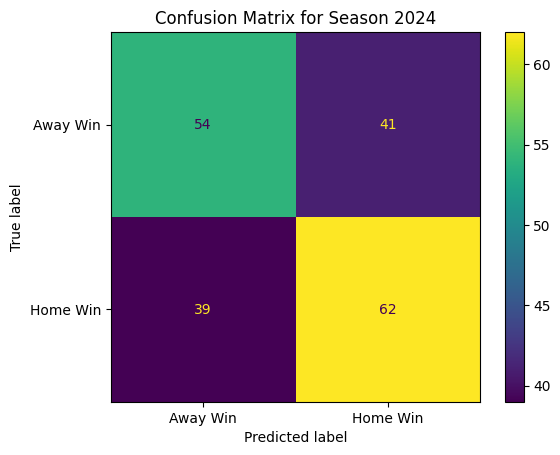

In [30]:
# Iterate over multiple seasons

print(f'Results for 2024')

y_preds = []
y_trues = []

for week in range(1, 15):
    print(f'Week {week:>2}:', end=' ')
    
    # Train on all data before the current season and week
    train_df = nfl_df3.query('Season < @season or (Season == @season and Week < @week)')
    test_df = nfl_2024_df2.query('Season == @season and Week == @week')
    
    # Assign training and testing data
    X_train = train_df[features]
    y_train = train_df[target]
    X_test = test_df[features]
    y_test = test_df[target]
    
    # Train k-NN model
    model = KNeighborsClassifier(n_neighbors=7)
    
    # Pipline for scaler and model predictions
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', KNeighborsClassifier(n_neighbors=7))
    ])
    
    #clf = model.fit(X_train, y_train)
    clf = pipe.fit(X_train, y_train)
    
    # Pipeline for LOF outlier detection
    pipe_outlier = Pipeline([
        ('scaler', StandardScaler()),
        ('lof', LocalOutlierFactor(novelty=True))
    ])
    
    pipe_outlier.fit(X_train)
    
    # Filter outliers using LoF
    y_test_novelty = pipe_outlier.predict(X_test)
    mask = [y == 1 for y in y_test_novelty]
    
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    y_pred = clf.predict(X_test)
    y_true = y_test
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f'accuracy = {accuracy:.2%}')
    
    y_preds += list(y_pred)
    y_trues += list(y_true)

# Season-wide evaluation
overall_accuracy = accuracy_score(y_trues, y_preds)
print(f'\nSeason {season}: Total Accuracy Score = {overall_accuracy:.2%}')
print(f'Classification Report for {season}:\n{classification_report(y_trues, y_preds, target_names=["Away Win", "Home Win"])}')

# Confusion Matrix
cm = confusion_matrix(y_trues, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Away Win", "Home Win"])
disp.plot()
plt.title(f"Confusion Matrix for Season {season}")
plt.grid(False)
plt.show()

In [31]:
# Train on all data before the current season and week
train_df = nfl_df3.query('Season < @season or (Season == @season and Week < @week)')
test_df = nfl_2024_df2.query('Season == @season and Week == @week')

# Assign training and testing data
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Train k-NN model
model = KNeighborsClassifier(n_neighbors=7)

# Pipline for scaler and model predictions
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier(n_neighbors=7))
])

#clf = model.fit(X_train, y_train)
clf = pipe.fit(X_train, y_train)

# Pipeline for LOF outlier detection
pipe_outlier = Pipeline([
    ('scaler', StandardScaler()),
    ('lof', LocalOutlierFactor(novelty=True))
])

pipe_outlier.fit(X_train)

# Filter outliers using LoF
y_test_novelty = pipe_outlier.predict(X_test)
mask = [y == 1 for y in y_test_novelty]

X_test = X_test[mask]
y_test = y_test[mask]

y_pred = clf.predict(X_test)    

In [32]:
# Define the matchups
matchups = [
    {'Team': 'MIA', 'Opp': 'NYJ', 'Spread': -6.0, 'Total': 45.0},
    {'Team': 'MIN', 'Opp': 'ATL', 'Spread': -5.5, 'Total': 46.0},
    {'Team': 'NYG', 'Opp': 'NOR', 'Spread': 4.5, 'Total': 41.0},
    {'Team': 'PHI', 'Opp': 'CAR', 'Spread': -12.5, 'Total': 46.0},
    {'Team': 'PIT', 'Opp': 'CLE', 'Spread': -7.0, 'Total': 43.5},
    {'Team': 'TAM', 'Opp': 'RAI', 'Spread': -6.5, 'Total': 46.0},
    {'Team': 'OTI', 'Opp': 'JAX', 'Spread': -3.5, 'Total': 39.5},
    {'Team': 'CRD', 'Opp': 'SEA', 'Spread': -2.5, 'Total': 44.5},
    {'Team': 'RAM', 'Opp': 'BUF', 'Spread': 4.0, 'Total': 49.5},
    {'Team': 'SFO', 'Opp': 'CHI', 'Spread': -3.5, 'Total': 44.0},
    {'Team': 'KAN', 'Opp': 'SDG', 'Spread': -4.0, 'Total': 43.0},
    {'Team': 'DAL', 'Opp': 'CIN', 'Spread': 5.5, 'Total': 49.5}
]

# Convert to dataframe
features_df = pd.DataFrame(matchups)

pred_df = features_df.copy()

features_df['Team'] = le.transform(features_df['Team'])
features_df['Opp'] = le.transform(features_df['Opp'])

# Predict scores using the trained pipelines
predicted_scores = clf.predict(features_df)

pred_df['Predictions'] = predicted_scores
print(pred_df)

   Team  Opp  Spread  Total  Predictions
0   MIA  NYJ    -6.0   45.0            1
1   MIN  ATL    -5.5   46.0            1
2   NYG  NOR     4.5   41.0            0
3   PHI  CAR   -12.5   46.0            1
4   PIT  CLE    -7.0   43.5            1
5   TAM  RAI    -6.5   46.0            0
6   OTI  JAX    -3.5   39.5            1
7   CRD  SEA    -2.5   44.5            0
8   RAM  BUF     4.0   49.5            0
9   SFO  CHI    -3.5   44.0            0
10  KAN  SDG    -4.0   43.0            0
11  DAL  CIN     5.5   49.5            0
